In [6]:
# data manipulation
import pandas as pd
import numpy as np
import scipy.io.arff

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# clustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline

## Exploração inicial

In [2]:
# carregando o dataset
data, meta = scipy.io.arff.loadarff(f'data/electricity-normalized.arff')
df = pd.DataFrame(data)

# Convertendo byte-strings para strings
str_df = df.select_dtypes([object]).stack().str.decode('utf-8').unstack()
for col in str_df:
    df[col] = str_df[col]

# ajeitar o tipo dos dados
nominal_cols = [col for col, dtype in zip(meta.names(), meta.types()) if dtype == 'nominal']
for col in nominal_cols:
    df[col] = df[col].astype('category')

df.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN


In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45312 entries, 0 to 45311
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   date       45312 non-null  float64 
 1   day        45312 non-null  category
 2   period     45312 non-null  float64 
 3   nswprice   45312 non-null  float64 
 4   nswdemand  45312 non-null  float64 
 5   vicprice   45312 non-null  float64 
 6   vicdemand  45312 non-null  float64 
 7   transfer   45312 non-null  float64 
 8   class      45312 non-null  category
dtypes: category(2), float64(7)
memory usage: 2.5 MB


In [4]:
df.isna().sum().sum()

0

In [5]:
df.describe()

,date,period,nswprice,nswdemand,vicprice,vicdemand,transfer
count,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000
mean,0.499080,0.500000,0.057868,0.425418,0.003467,0.422915,0.500526
std,0.340308,0.294756,0.039991,0.163323,0.010213,0.120965,0.153373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031934,0.250000,0.035127,0.309134,0.002277,0.372346,0.414912
50%,0.456329,0.500000,0.048652,0.443693,0.003467,0.422915,0.414912
75%,0.880547,0.750000,0.074336,0.536001,0.003467,0.469252,0.605702
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- 45312 instâncias, com 8 features.
- Sem valores nulos.
- Todos os atributos numéricos (7 features de um total de 8) estão normalizados entre 0 e 1 (estando, portanto, todos na mesma escala), sendo valores contínuos.
- Apenas uma feature categórica: day, que representa o dia da semana. Como é um atributo categórico, precisa ser convertido para numérico, mas como é uma feature ordinal, já que os dias seguem uma ordem, talvez uma possível abordagem seja apenas converter os dias que estão como strings "1", "2", etc, direto para números, 1, 2. Mas alguns algoritmos ainda podem não lidar tão bem com as distâncias relativas, então ainda pode ser interessante testar one hot encoding também.

## Visualizando as distribuições

In [8]:
numeric_cols = df.select_dtypes(include='number')
numeric_cols.columns

Index(['date', 'period', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand',
       'transfer'],
      dtype='object')

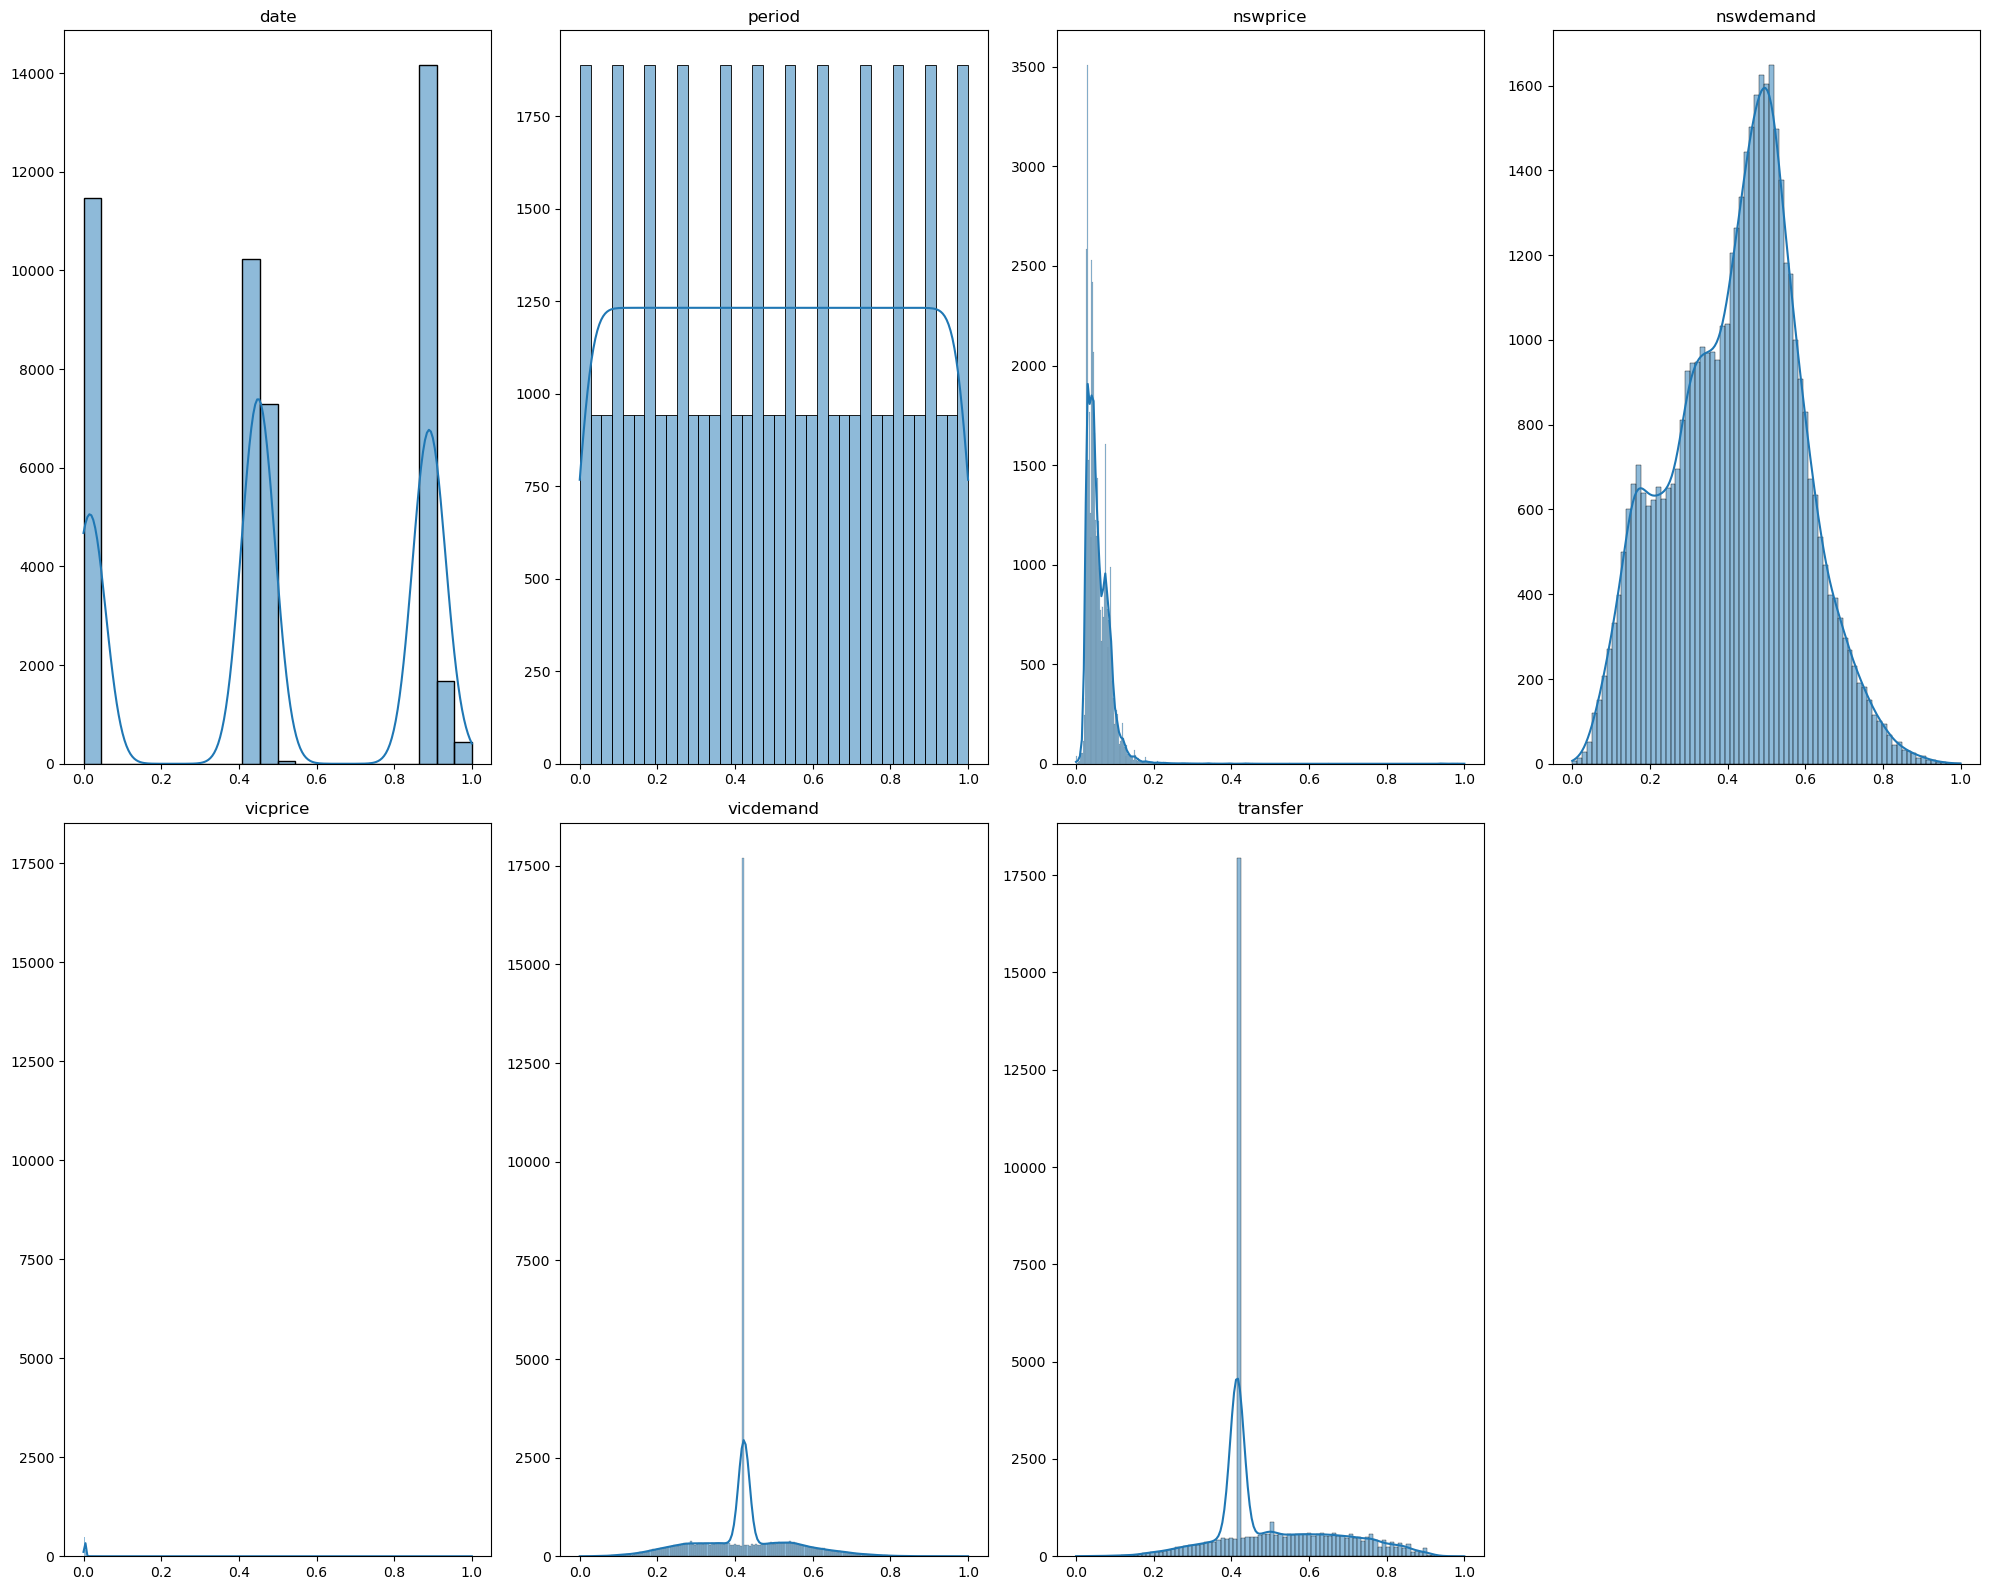

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(20, 16))
axes = axes.flatten()

for i, column in enumerate(numeric_cols.columns):
    sns.histplot(numeric_cols[column], ax=axes[i], kde=True)
    axes[i].set_title(column)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

axes[7].set_visible(False)
plt.tight_layout()
plt.show()

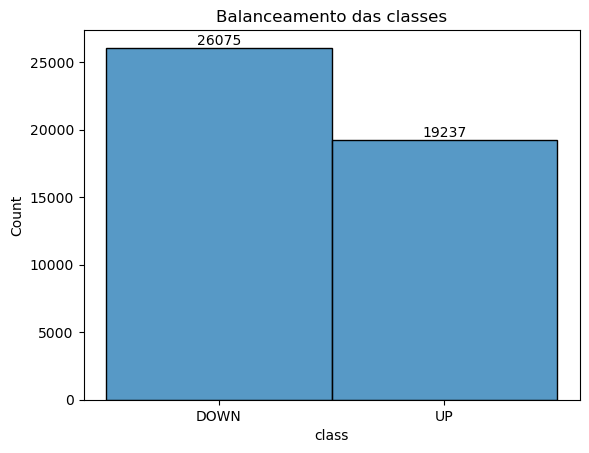

In [23]:
ax = sns.histplot(df['class'])

for container in ax.containers:
    ax.bar_label(container)

plt.title("Balanceamento das classes")
plt.show()

/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_96055/2180536327.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


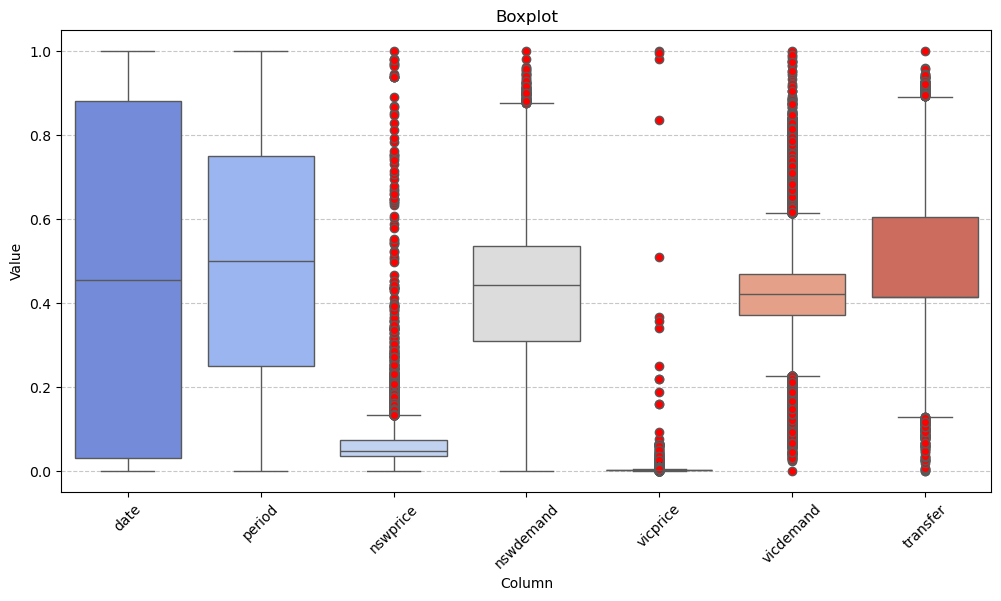

In [24]:
df_melted = numeric_cols.melt(var_name='Column', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(
    x="Column", y="Value", 
    data=df_melted, 
    palette='coolwarm', 
    flierprops= {
        "marker": "o",
        "markerfacecolor": 'red',
        "markersize": 6
    }
)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Boxplot')
plt.show()

A normalização dos dados desde o começo torna difícil interpretar suas distribuições.
- Comos os dados foram coletados entre 7 de Maio de 1996 até 5 de Dezembro de 1998 e normalizados, temos que a maioria dos dados (ou todos) foram coletados na data inicial, num período mais ou menos no meio entre esses 2 limites e também por volta da data final.
- Quanto ao preço da energia em New South Wales, podemos observar que a distruibuição tem a maior parte dos seus dados concentrados no intervalo de 0.0 a 0.2, uma distribuição fortemente enviesada para a direita (right-skewed) causada por possíveis grandes outliers. O preço da energia em victoria segue um padrão semelhante, na maioria dos casos está com um preço em torno do preço mínimo, mas tem alguns casos no qual o preço se torna muito alto, deixando a distribuição fortemente right-skewed. Talvez teria sido melhor utilizar outro tipo de normalização, já que o min-max acaba sendo sensível a outliers. Pode ser interetessante testar algumas técnicas para lidar com os possíveis outliers nessas distribuições.
- A demanda de energia se apresenta bem distribuída em New South Wales, raramente alcançando as demandas máximas. O mesmo com Victoria, só que com uma demanda média muito mais focada em um valor.
- Transfer apresenta uma distribuição semelhante a vicdemand.
- Existe um certo grau de desbalanceamento, com 26 mil instâncias de UP e 19 mil instâncias de down, com UP representando 57% das instâncias. Talvez seja interessante aplicar alguma técnica de balanceamento como Random OverSampling.

## Redução de dimensionalidade

### PCA

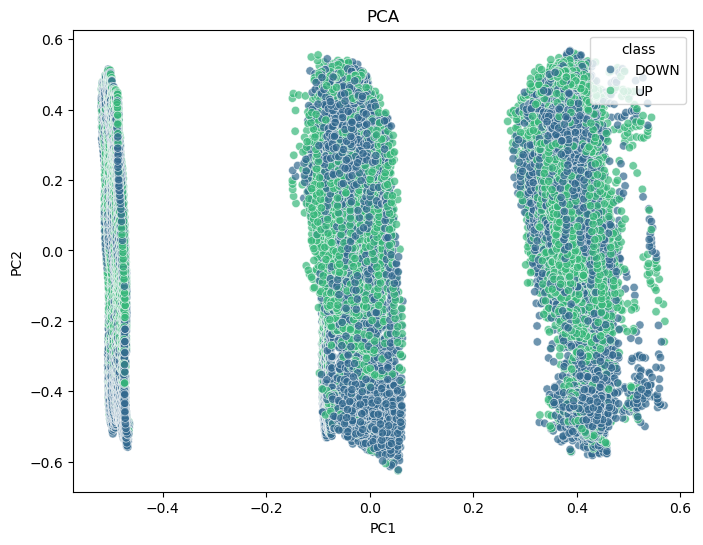

In [4]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.drop(columns=['day', 'class']))

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

pca_df['class'] = df['class']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df, palette='viridis', alpha=0.7)
plt.title('PCA')
plt.show()

### T-SNE

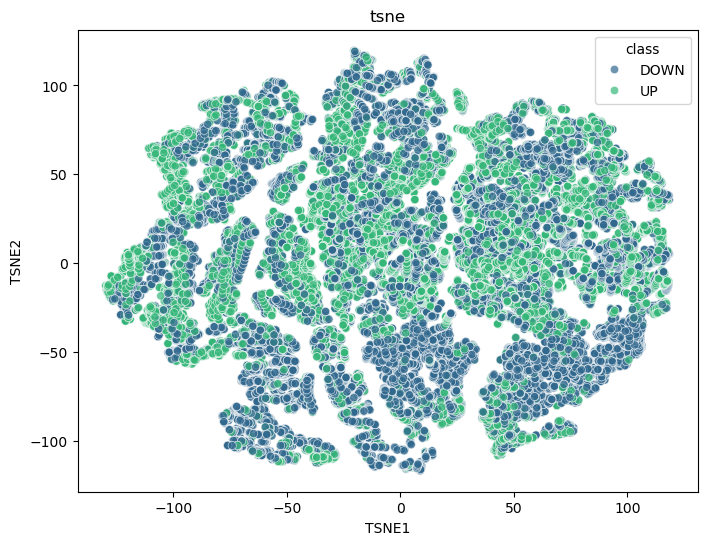

In [8]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df.drop(columns=['day', 'class']))

tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])

tsne_df['class'] = df['class']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='class', data=tsne_df, palette='viridis', alpha=0.7)
plt.title('tsne')
plt.show()